Plot all the data defect correlation versus sample elasticity curves.

# Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import pickle

# Helper Functions:

In [2]:
def unstack_saved_list_of_series(list_of_list_of_series):
    unstacked_1 = [pd.concat(temp_list_of_series, ignore_index = True) for temp_list_of_series in list_of_list_of_series]
    return pd.concat(unstacked_1, axis=1).T

# Hyperparameters:

link fn to true beta series:

In [3]:
sample_size_of_interest = 1000

In [4]:
make_greyscale = False

In [5]:
if make_greyscale:
    high_contrast_greys = ['#000000', '#808080', '#C0C0C0']
    sns.set_palette(high_contrast_greys)
    savefile_suffix = '_greyscale'
else:
    sns.set_palette('deep')
    savefile_suffix = ''

### run one of the code chunks below:

In [15]:
generators_and_betas = [
    ('Logit', 1),
    ('Probit', 0.61),
    ('CLogLog', 0.564)
]
final_fig_suffix = '1'

In [12]:
generators_and_betas = [
    ('Logit', 1),
    ('Probit', 1),
    ('CLogLog', 1)
]
final_fig_suffix = '1_all'
true_logit_beta = 1

In [14]:
generators_and_betas = [
    ('Logit', -1),
    ('Probit', -1),
    ('CLogLog', -1)
]
final_fig_suffix = 'sans_1_all'
true_logit_beta = -1

# Read data in:

In [15]:
all_data_per_generator = {}

In [16]:
for link, true_beta in tqdm(generators_and_betas):   
    pickle_filename = f'all_raw_data_{link}_{true_beta}.pickle'
    with open(pickle_filename, 'rb') as handle:
        biased_sampler = pickle.load(handle)
    
    unstacked_values = []
    
    for i in tqdm(range(6)):
        unstacked_values.append(
            unstack_saved_list_of_series(biased_sampler[i][sample_size_of_interest])
        )
    
    values_per_link_fn = []
    
    for i in tqdm(range(3)):
        temp_vals = [unstacked_value[i] for unstacked_value in unstacked_values]
    
        val_names = ['jn_biased', 'ddc_biased', 'samp_biased', 
                     'jn_intended', 'ddc_intended', 'samp_intended']
    
        for i in range(6):
            temp_vals[i].name = val_names[i]
            temp_vals[i] = temp_vals[i].reset_index(drop = True)
            
        values_per_link_fn.append(pd.concat(temp_vals, axis=1))
        
    all_data_per_generator[link] = values_per_link_fn

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|                                                                                            | 0/6 [00:00<?, ?it/s]
%|██████████████                                                                      | 1/6 [00:00<00:03,  1.59it/s]
%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.40it/s]
%|██████████████████████████████████████████                                          | 3/6 [00:01<00:01,  2.87it/s]
%|████████████████████████████████████████████████████████                            | 4/6 [00:01<00:00,  2.22it/s]
%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:02<00:00,  2.49it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]

 33%|████████████████████████████                        

# Create Graph:

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|████████████████████████████                                                        | 1/3 [00:22<00:45, 22.71s/it]
%|████████████████████████████████████████████████████████                            | 2/3 [00:45<00:22, 22.91s/it]
 33%|████████████████████████████                                                        | 1/3 [01:09<02:18, 69.01s/it]
%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|████████████████████████████                                                        | 1/3 [00:24<00:48, 24.09s/it]
%|████████████████████████████████████████████████████████                            | 2/3 [00:47<00:23, 23.55s/it]
 67%|█████████████████████████████████████████████████████

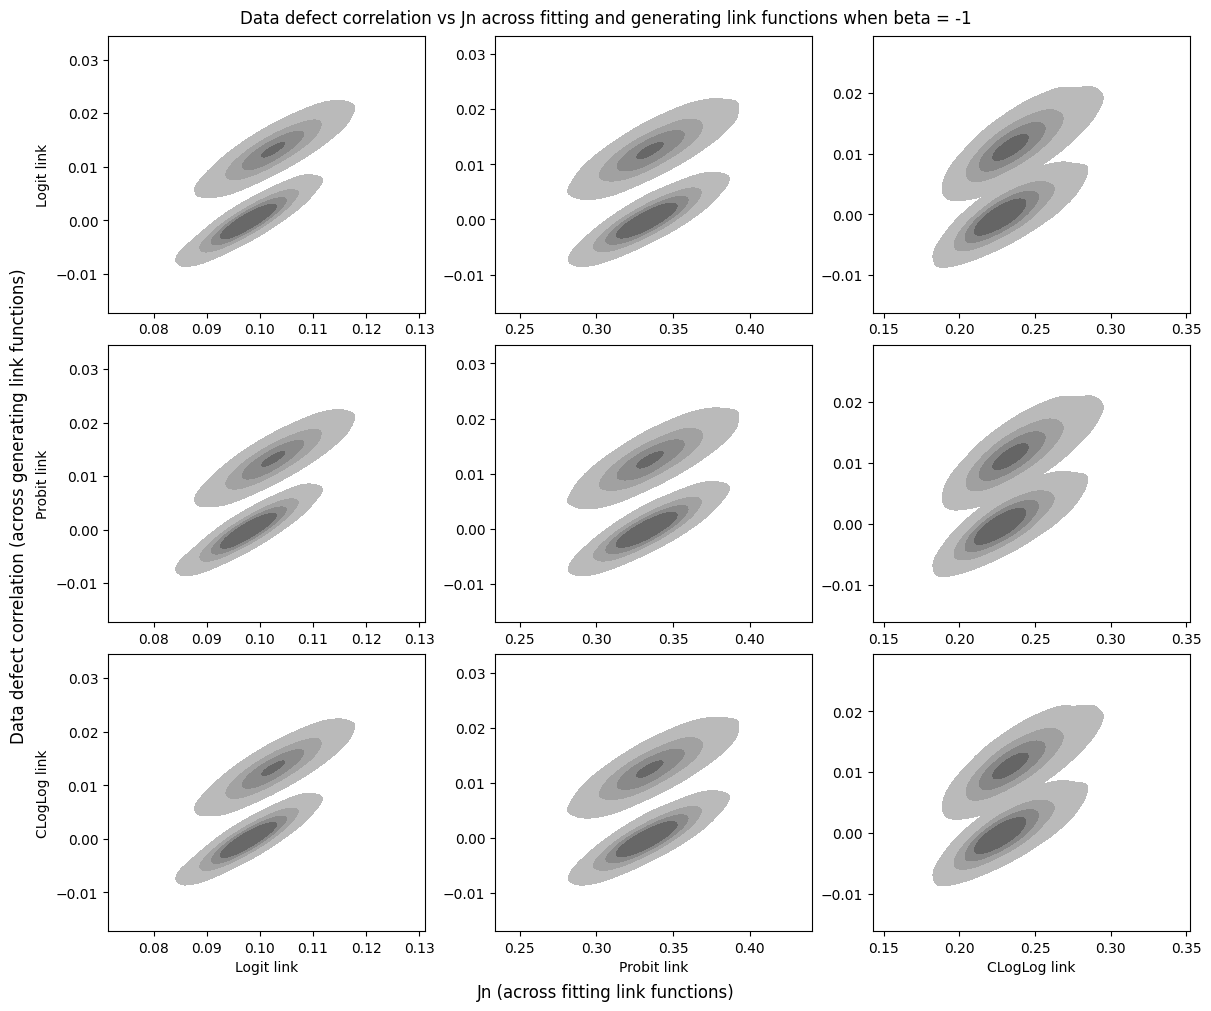

In [11]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 3, 
                         constrained_layout=True, 
                         figsize=(12, 10))

generating_functions = ['Logit', 'Probit', 'CLogLog']
for generating_fn_ix in trange(3):
    generating_function = generating_functions[generating_fn_ix]
    
    for link_fn in trange(3):
        ax = axes[generating_fn_ix][link_fn]
        temp_view = values_per_link_fn[link_fn]
        
        c1 = temp_view[['jn_biased', 'ddc_biased']].copy()
        c1.columns = ['jn', 'ddc']
        c1['Sampling Scheme'] = 'Biased' 
        
        c2 = temp_view[['jn_intended', 'ddc_intended']].copy()
        c2.columns = ['jn', 'ddc']
        c2['Sampling Scheme'] = 'Intended' 
        
        c_agg = pd.concat([c1, c2]).reset_index(drop=True)
        
        sns.kdeplot(
            data = c_agg, 
            x='jn',
            y = 'ddc', 
            hue='Sampling Scheme', 
            fill=True, 
            bw_adjust=1.8, 
            ax = ax, levels=5, 
            legend=False
        )
        
        if link_fn == 0:
            ax.set_ylabel(f"{generating_function} link")
        else:
            ax.set_ylabel("")

        if generating_fn_ix == 2:
            ax.set_xlabel(f"{generating_functions[link_fn]} link")            
        else: 
            ax.set_xlabel("") 


fig.suptitle('Data defect correlation vs Jn across ' + \
             f'fitting and generating link functions when beta = {true_logit_beta}')
fig.supxlabel('Jn (across fitting link functions)')
fig.supylabel('Data defect correlation (across generating link functions)')
plt.savefig(f'ddc_vs_sample_elasticity_{final_fig_suffix}.png')

# custom greyscale version:

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|████████████████████████████                                                        | 1/3 [00:22<00:45, 22.54s/it]
%|████████████████████████████████████████████████████████                            | 2/3 [00:45<00:22, 22.82s/it]
 33%|████████████████████████████                                                        | 1/3 [01:08<02:17, 68.50s/it]
%|                                                                                            | 0/3 [00:00<?, ?it/s]
%|████████████████████████████                                                        | 1/3 [00:22<00:44, 22.48s/it]
%|████████████████████████████████████████████████████████                            | 2/3 [00:45<00:22, 22.91s/it]
 67%|█████████████████████████████████████████████████████

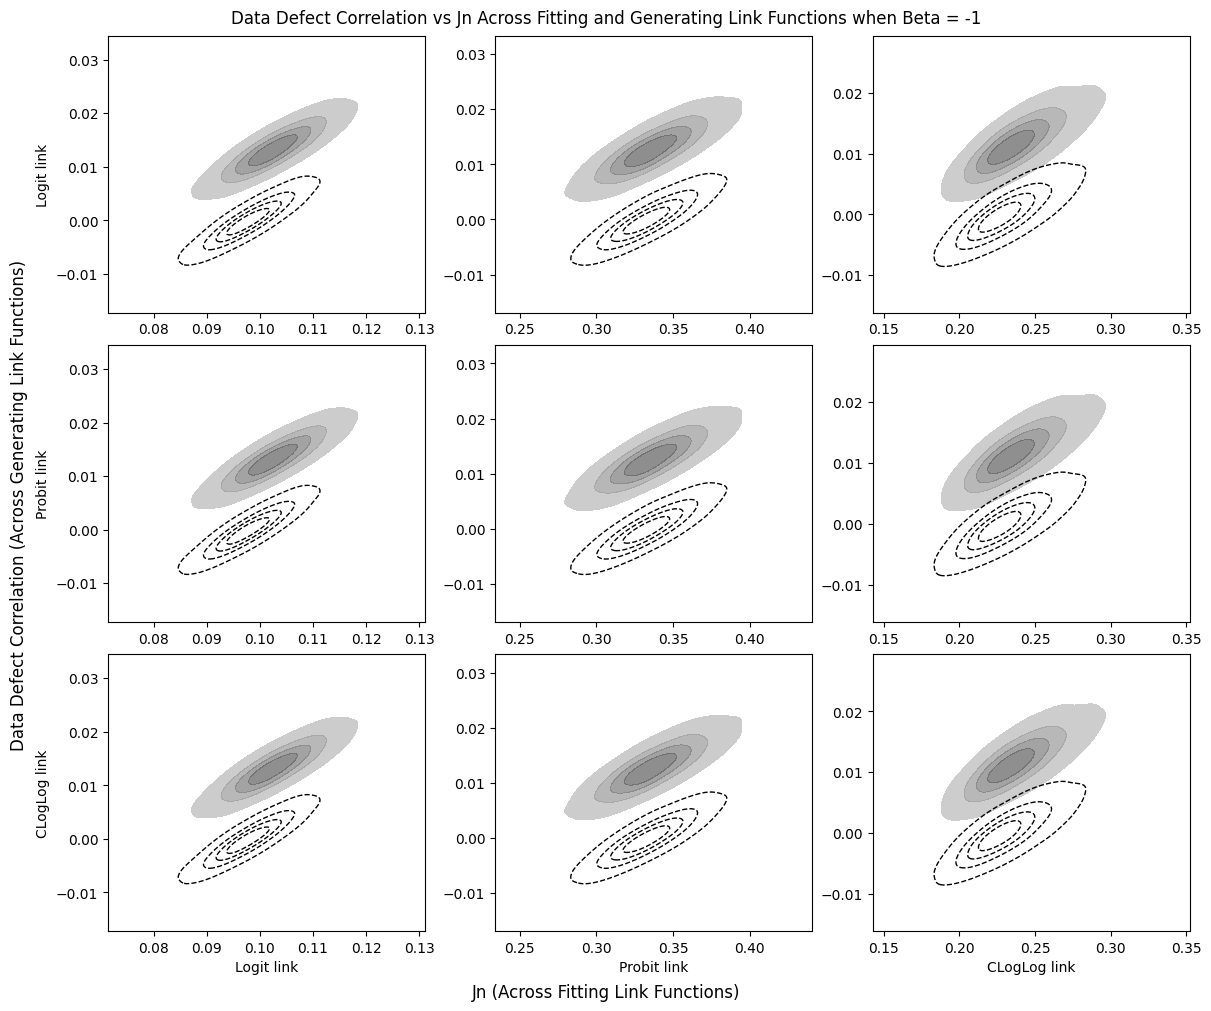

In [17]:
high_contrast_greys = ['#000000', '#808080', '#C0C0C0']
sns.set_palette(high_contrast_greys)
savefile_suffix = '_greyscale'

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, 
                         constrained_layout=True, 
                         figsize=(12, 10))

generating_functions = ['Logit', 'Probit', 'CLogLog']
for generating_fn_ix in trange(3):
    generating_function = generating_functions[generating_fn_ix]
    
    for link_fn in trange(3):
        ax = axes[generating_fn_ix][link_fn]
        temp_view = values_per_link_fn[link_fn]
        
        c1 = temp_view[['jn_biased', 'ddc_biased']].copy()
        c1.columns = ['jn', 'ddc']
        c1['Sampling Scheme'] = 'Biased' 
        
        c2 = temp_view[['jn_intended', 'ddc_intended']].copy()
        c2.columns = ['jn', 'ddc']
        c2['Sampling Scheme'] = 'Intended' 
        
        c_agg = pd.concat([c1, c2]).reset_index(drop=True)
        
        sns.kdeplot(
            data=c_agg[c_agg['Sampling Scheme'] == 'Biased'], 
            x='jn',
            y='ddc', 
            fill=True, 
            bw_adjust=1.8, 
            ax=ax, 
            levels=5,
            color='#404040',  # Dark grey
            alpha=0.7,
            legend=False
        )
        
        # Intended sampling scheme - hatched pattern with lighter color
        sns.kdeplot(
            data=c_agg[c_agg['Sampling Scheme'] == 'Intended'], 
            x='jn',
            y='ddc', 
            fill=False,  # No fill, just contour lines
            bw_adjust=1.8, 
            ax=ax, 
            levels=5,
            color='#000000',  # Black contour lines
            linewidths=1,  # Thicker lines for better visibility
            linestyles='--',  # Dashed lines for distinction
            legend=False
        )
        
        if link_fn == 0:
            ax.set_ylabel(f"{generating_function} link")
        else:
            ax.set_ylabel("")

        if generating_fn_ix == 2:
            ax.set_xlabel(f"{generating_functions[link_fn]} link")            
        else: 
            ax.set_xlabel("") 


fig.suptitle('Data Defect Correlation vs Jn Across ' + \
             f'Fitting and Generating Link Functions when Beta = {true_logit_beta}')
fig.supxlabel('Jn (Across Fitting Link Functions)')
fig.supylabel('Data Defect Correlation (Across Generating Link Functions)')
plt.savefig(f'ddc_vs_sample_elasticity_{final_fig_suffix}{savefile_suffix}.png')